# ***Import Libraries***

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from source.engine.FTP_engine import FTPModel as FTP

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000

C:\Users\capoma\AppData\Local\Temp\ipykernel_9848\877008696.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# ***Load Data***

## ***Data Modelo***

In [3]:
path = "outputs/"
file = "output_sugerido_35_dia_previo.xlsx"

df = pd.read_excel(path + file, converters={'id_embarcacion':str})

name_fecha = 'fecha_produccion'
df.loc[:, name_fecha] = pd.to_datetime(
            df.loc[:, name_fecha], format="%Y/%m/%d"
        )
# df['y-m'] = df[name_fecha].apply(lambda x: '{0}-{1}'.format(x.year, x.isocalendar()[1]))

name_tempo = 'temporada'


df[name_tempo] =  pd.Categorical(
            df[name_tempo],
            ['2018-I', '2018-II', '2019-I', '2019-II', '2020-I', '2020-II', '2021-I', '2021-II'],
        )

df.loc[df['planta'].isna(), 'planta'] = 'Planta NA'

df.head()

CBOD        Embarc Ind Propiedad  Orden_de_Prioridad   Tipo Tr Zona de Pesca       planta sort_tipo_embarc fecha_produccion id_embarcacion  volumen temporada  zona_de_pesca_id  flag_dia_adicional Prioridad 1 Prioridad 2 Prioridad 3 Prioridad 4 Prioridad 5 Prioridad 6 Prioridad 7 Prioridad 8  flag_termino planta_sugerida
0  388.94       COQUI X       Tercera                   2  Terceros       Pisco S    PISCO SUR      3 Exclusivo       2018-04-07          28225   38.980    2018-I                14                   0     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN             0         Pisco S
1  353.77     COQUI XII       Tercera                   3  Terceros       Pisco S    PISCO SUR      3 Exclusivo       2018-04-07          11074   41.950    2018-I                14                   0     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN             0         Pisco S
2  339.00  SAN JUDAS II       Tercera                   5  Terceros       Pisco N  PISCO NORTE      3 Exclusivo       2018-04-07          41816  219.020    2018-I                13                   0     Pisco N     Pisco S         NaN         NaN         NaN         NaN         NaN         NaN             0         Pisco N
3  335.08      COQUI IX       Tercera                   6  Terceros       Pisco S    PISCO SUR      3 Exclusivo       2018-04-07          11071   33.375    2018-I                14                   0     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN             0         Pisco S
4  296.85     MACABI 10       Tercera                  11  Terceros      Chimbote     CHIMBOTE      3 Exclusivo       2018-04-07          29416   31.935    2018-I                 3                   0    Chimbote     Samanco         NaN         NaN         NaN         NaN         NaN         NaN             0        Chimbote

## ***Flags***

In [4]:
# Flag tiene planta sugerida
mask_plant_notna = (df['planta_sugerida'].notna())

# Flag días de pesca adicionales
mask_adicional = (df['flag_dia_adicional'] == 1)

# Flag barcos de TASA
mask_prop = (df['Ind Propiedad'] == 'Propia')

# Flag término de temporada con días de pesca adicional
mask_fin_tempor = (df['flag_termino'] == 1)

# Flag modelo
mask_model = mask_plant_notna & ~mask_fin_tempor

# Flag terceros perdida de volumen
mask_perd_terceros = ~mask_plant_notna & ~ mask_fin_tempor

### ***Modelo***

## ***Consideraciones***

1. Aparecen Nan debido a los registros creados de pesca adicional (no tienen porqué hacer match ya que fueron creados.)
   
2. Aparecen 'MATARANI' y 'ATICO' debido a que los registros creados de pesca adicional hacen match con pesca real que se tuvo en otras plantas.


## ***Volumen global Real (TASA + Terceros)***

In [5]:
vol_all = pd.pivot_table(df[~mask_adicional].groupby(['temporada', 'planta'], as_index=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta' )
vol_all

temporada        2018-I     2018-II      2019-I    2019-II      2020-I     2020-II      2021-I     2021-II
planta                                                                                                    
CALLAO       113990.055   62736.004   71999.195  22565.690  124247.640   59569.690   90926.835  116230.735
CHIMBOTE     164052.120  104236.470   87257.615  78619.170  132157.555  131029.260  161053.097   67813.415
MALABRIGO    116768.140   57380.145  133311.605  59253.300  129001.400  155901.315  119162.780   60620.745
PISCO NORTE   28510.315   29200.510   21230.660      0.000       0.000       0.000       0.000       0.000
PISCO SUR     70667.420   45720.110   46989.655   1058.145       0.000   25100.645   32111.040   47928.455
SAMANCO       42702.875   31183.115   18335.130  20395.165    6421.975   36818.870   37443.405   17884.560
SUPE          67618.005   38474.650   20560.810  18434.970       0.000   44397.455   17422.920   38286.985
VEGUETA      107672.745   63116.655   33003.045  31033.935  100004.180   66255.870   58068.650   64684.325

## ***Volumen TASA Real (propios)***

In [6]:
vol_tasa_real = pd.pivot_table(df[mask_prop & ~mask_adicional].groupby(['temporada', 'planta'], as_index=False, dropna=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta')

temp = vol_tasa_real.head(1).copy()
temp.index = ['Planta NA']
temp.loc[:, :] = 0.0
vol_tasa_real = pd.concat([vol_tasa_real, temp], ignore_index=False)

vol_tasa_real

temporada       2018-I    2018-II      2019-I    2019-II      2020-I    2020-II      2021-I    2021-II
CALLAO       77743.820  49174.269   38377.295  20941.065  101145.625  44859.720   67095.860  92543.600
CHIMBOTE     57144.055  50568.990   44104.270  28243.420   85068.795  89920.010  103822.972   8394.250
MALABRIGO    99856.895  28508.595  101133.545  28857.035   62612.935  51735.475   61058.855  35361.915
PISCO NORTE  27255.265  26487.940   18511.485      0.000       0.000      0.000       0.000      0.000
PISCO SUR    64101.565  42611.060   41514.800   1058.145       0.000  22629.305   28062.745  47670.045
SAMANCO      21277.255  20560.640   10373.370  14309.925    5835.890  31475.040   36388.480   3824.745
SUPE         46361.590  34678.560   18246.160  10282.950       0.000  42072.170   17422.920  37298.785
VEGUETA      75879.820  44748.780   25163.310  20772.760   74437.790  41359.580   35620.045  50939.535
Planta NA        0.000      0.000       0.000      0.000       0.000      0.000       0.000      0.000

In [7]:
vol_tasa_real.sum(axis=0)

temporada
2018-I     469620.265
2018-II    297338.834
2019-I     297424.235
2019-II    124465.300
2020-I     329101.035
2020-II    324051.300
2021-I     349471.877
2021-II    276032.875
dtype: float64

## ***Volumen Real Terceros***

In [8]:
vol_terceros = pd.pivot_table(df[(~mask_prop) & (~mask_adicional)].groupby(['temporada', 'planta'], as_index=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta')
vol_terceros

temporada        2018-I    2018-II     2019-I    2019-II     2020-I     2020-II     2021-I    2021-II
planta                                                                                               
CALLAO        36246.235  13561.735  33621.900   1624.625  23102.015   14709.970  23830.975  23687.135
CHIMBOTE     106908.065  53667.480  43153.345  50375.750  47088.760   41109.250  57230.125  59419.165
MALABRIGO     16911.245  28871.550  32178.060  30396.265  66388.465  104165.840  58103.925  25258.830
PISCO NORTE    1255.050   2712.570   2719.175      0.000      0.000       0.000      0.000      0.000
PISCO SUR      6565.855   3109.050   5474.855      0.000      0.000    2471.340   4048.295    258.410
SAMANCO       21425.620  10622.475   7961.760   6085.240    586.085    5343.830   1054.925  14059.815
SUPE          21256.415   3796.090   2314.650   8152.020      0.000    2325.285      0.000    988.200
VEGUETA       31792.925  18367.875   7839.735  10261.175  25566.390   24896.290  22448.605  13744.790

In [9]:
vol_terceros.sum(axis=0)

temporada
2018-I     242361.410
2018-II    134708.825
2019-I     135263.480
2019-II    106895.075
2020-I     162731.715
2020-II    195021.805
2021-I     166716.850
2021-II    137416.345
dtype: float64

## ***Volumen Modelo (All)***

In [10]:
vol_model = pd.pivot_table(df[mask_model].groupby(['temporada', 'planta'], as_index=False, dropna=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta', dropna=False, aggfunc=np.sum)
vol_model

temporada           2018-I       2018-II         2019-I       2019-II         2020-I        2020-II         2021-I        2021-II
planta                                                                                                                           
CALLAO       107267.545000  60692.434000   70003.485000  22565.690000  122086.000000   54861.325000   89585.495000  100427.285000
CHIMBOTE     150039.145000  87043.945000   85437.085000  74548.630000  127580.920000  128972.715000  150242.740000   67635.755000
MALABRIGO    115698.245000  55365.265000  125167.160000  49878.910000  110623.480000  153368.460000  115507.075000   60620.745000
PISCO NORTE   27541.600000  27434.735000   21230.660000      0.000000       0.000000       0.000000       0.000000       0.000000
PISCO SUR     61446.890000  44154.040000   46796.120000   1058.145000       0.000000   25100.645000   31900.185000   44687.280000
Planta NA      9180.224527  21344.066977    2849.775928   1955.154809   18227.896148    2091.901298    9940.181192   11229.171758
SAMANCO       42498.955000  26974.145000   18335.130000  20395.165000    6421.975000   36486.715000   35075.400000   17884.560000
SUPE          67213.445000  38474.650000   20560.810000  18283.915000       0.000000   44397.455000   17422.920000   38286.985000
VEGUETA      102713.375000  62640.550000   32593.675000  30373.535000   96766.515000   65557.975000   55328.055000   64684.325000

In [11]:
vol_model.sum(axis=0)

temporada
2018-I     683599.424527
2018-II    424123.830977
2019-I     422973.900928
2019-II    219059.144809
2020-I     481706.786148
2020-II    510837.191298
2021-I     505002.051192
2021-II    405456.106758
dtype: float64

## ***Volumen TASA Modelo***

In [12]:
vol_model_tasa = pd.pivot_table(df[mask_model & mask_prop].groupby(['temporada', 'planta'], as_index=False, dropna=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta', dropna=False, aggfunc=np.sum)
vol_model_tasa

temporada          2018-I       2018-II        2019-I       2019-II        2020-I       2020-II        2021-I       2021-II
planta                                                                                                                     
CALLAO       76856.125000  48192.984000  38377.295000  20941.065000  98983.985000  41454.095000  67006.000000  77104.385000
CHIMBOTE     54555.695000  37843.160000  43750.690000  27284.325000  82407.695000  88127.675000  93216.890000   8394.250000
MALABRIGO    99856.895000  27325.255000  96336.685000  25251.360000  50724.820000  51685.305000  58956.505000  35361.915000
PISCO NORTE  26908.825000  24722.165000  18511.485000      0.000000      0.000000      0.000000      0.000000      0.000000
PISCO SUR    59950.680000  41044.990000  41321.265000   1058.145000      0.000000  22629.305000  28062.745000  44428.870000
Planta NA     9180.224527  21344.066977   2849.775928   1955.154809  18227.896148   2091.901298   9940.181192  11229.171758
SAMANCO      21277.255000  16430.990000  10373.370000  14309.925000   5835.890000  31142.885000  34020.475000   3824.745000
SUPE         46057.035000  34678.560000  18246.160000  10282.950000      0.000000  42072.170000  17422.920000  37298.785000
VEGUETA      73401.195000  44424.240000  24945.470000  20772.760000  72886.495000  40939.600000  33221.690000  50939.535000

## ***Diferencia Tasa VS Model***

In [13]:
(vol_tasa_real - vol_model_tasa).sum(axis=0)

temporada
2018-I     1576.335473
2018-II    1332.423023
2019-I     2712.039072
2019-II    2609.615191
2020-I       34.253852
2020-II    3908.363702
2021-I     7624.470808
2021-II    7451.218242
dtype: float64

In [14]:
vol_model[vol_model.index == 'Planta NA'].T

planta        Planta NA
temporada              
2018-I      9180.224527
2018-II    21344.066977
2019-I      2849.775928
2019-II     1955.154809
2020-I     18227.896148
2020-II     2091.901298
2021-I      9940.181192
2021-II    11229.171758

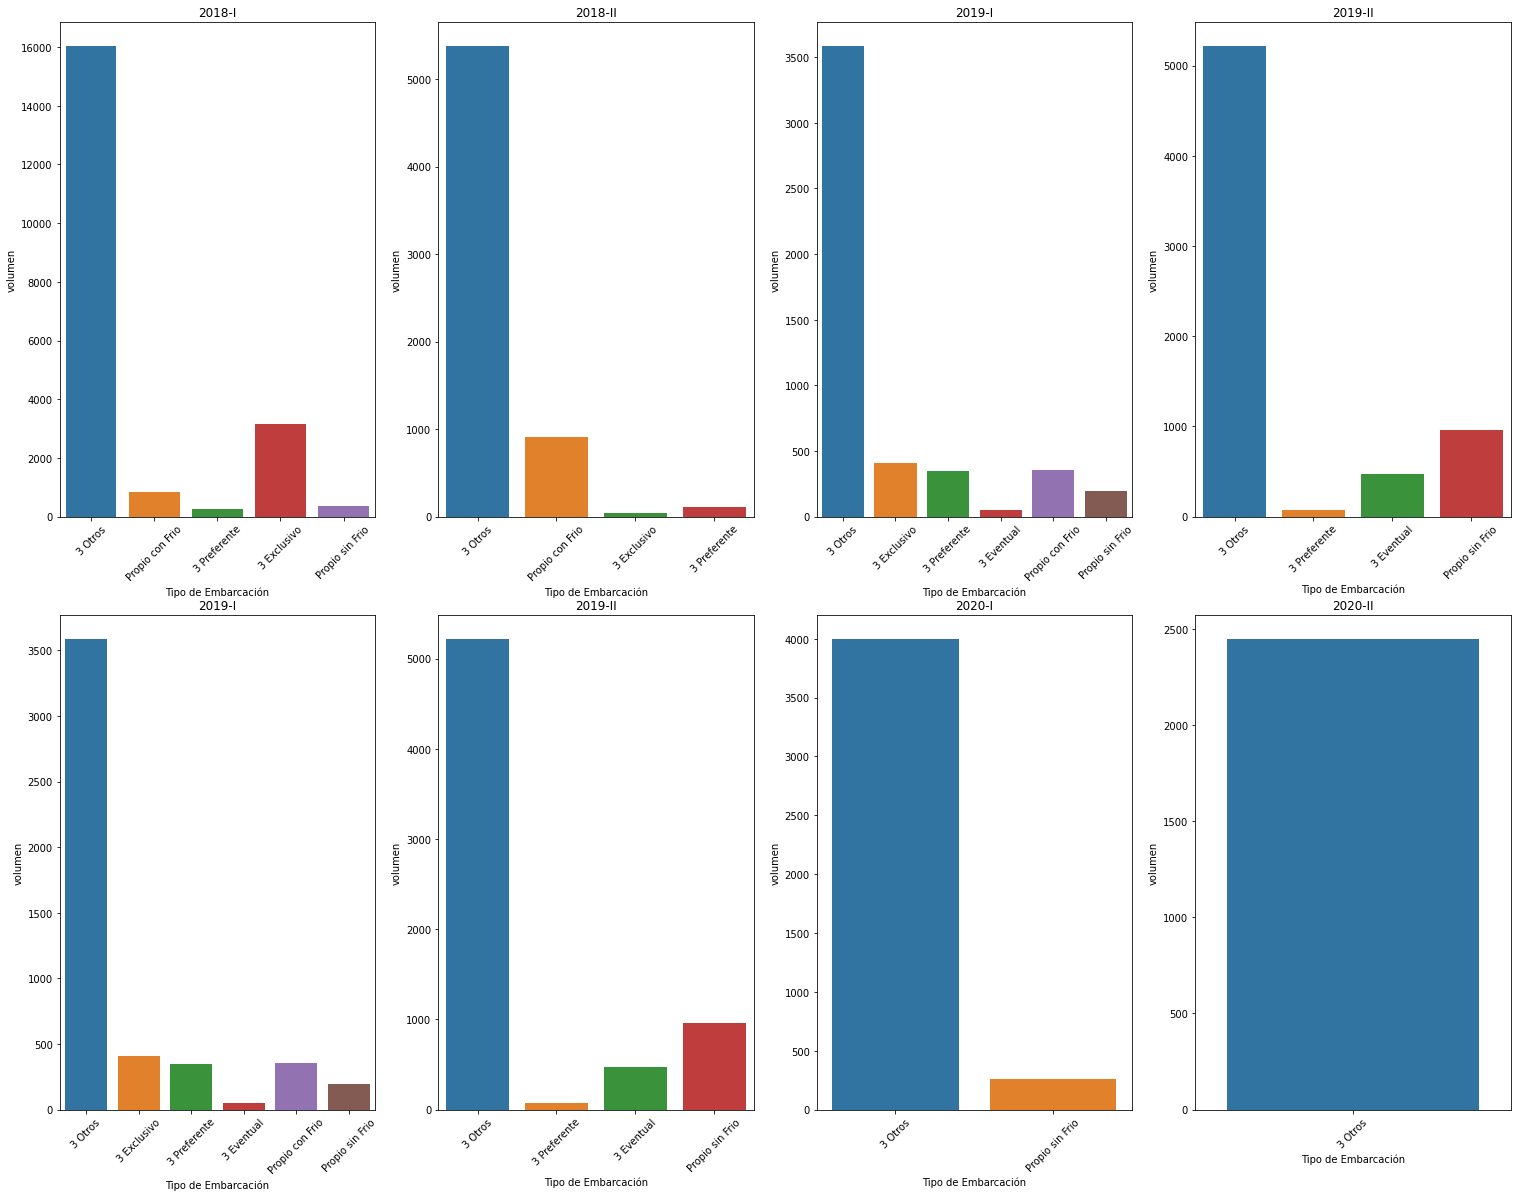

In [15]:

data = df[~mask_fin_tempor & ~mask_plant_notna]
# formatter = FuncFormatter(thousands)
fig, ax = plt.subplots(2, 4, figsize=(26, 20))
values = ['2018-I', '2018-II', '2019-I', '2019-II', '2020-I', '2020-II', '2021-I', '2021-II']
for i in range(2):
    for j in range(4):
        k = 2*i + j
        sns.barplot(ax=ax[i, j], data=data[data['temporada'] == values[k]], x='sort_tipo_embarc', y='volumen', estimator=sum, ci=None)
        # ax[i, j].yaxis.set_major_formatter(formatter)
        ax[i, j].set_title(values[k])
        # ax[i, j].bar_label(ax.containers[0])
        # ax[i, j].xticks(rotation=45)
        ax[i, j].tick_params(axis='x', labelrotation=45)
        ax[i, j].set_xlabel('Tipo de Embarcación')     

# fig.set_xticklabels(rotation=45)   
plt.show()

In [76]:
df.columns

Index(['CBOD', 'Embarc', 'Ind Propiedad', 'Orden_de_Prioridad', 'Tipo Tr',
       'Zona de Pesca', 'periodo', 'planta', 'sort_tipo_embarc',
       'fecha_produccion', 'id_embarcacion', 'volumen', 'temporada',
       'zona_de_pesca_id', 'Prioridad 1', 'Prioridad 2', 'Prioridad 3',
       'Prioridad 4', 'Prioridad 5', 'Prioridad 6', 'Prioridad 7',
       'Prioridad 8', 'planta_sugerida', 'y-m', 'rend'],
      dtype='object')

In [10]:
cols = ['temporada', 'planta']

mask = (df['planta_sugerida'].isna())
df_grouped = df[mask].groupby(cols, as_index=False)['volumen'].sum()

fig = px.histogram(df_grouped, x="temporada", y="volumen",
             color='planta', barmode='group',
            #  histfunc='avg',
             height=400)
fig.update_layout(
    template='plotly_dark'
)
fig.show()

In [69]:
cols = ['temporada', 'planta']

mask = (df['planta_sugerida'].isna())
df_grouped = df[mask].groupby(cols, as_index=False)['volumen'].sum()

fig = px.histogram(df_grouped, x="temporada", y="volumen",
             color='planta', barmode='group',
            #  histfunc='avg',
             height=400)
fig.update_layout(
    template='plotly_dark'
)
fig.show()

In [49]:
cols = ['temporada', 'planta']

mask = (df['planta_sugerida'].isna())
df_grouped = df[mask].groupby(cols, as_index=False)['volumen'].sum()

fig = px.histogram(df_grouped, x="temporada", y="volumen",
             color='planta', barmode='group',
            #  histfunc='avg',
             height=400)
fig.update_layout(
    template='plotly_dark'
)
fig.show()

In [13]:
cols = ['temporada', 'Zona de Pesca']

mask = (df['planta_sugerida'].isna())
df_grouped = df[mask].groupby(cols, as_index=False)['volumen'].sum()

fig = px.histogram(df_grouped, x="temporada", y="volumen",
             color='Zona de Pesca', barmode='group',
            #  histfunc='avg',
             height=400)
fig.show()

In [8]:
fig = px.bar(df, x="planta", y="volumen", color="planta",
  animation_frame="y-m", animation_group="Zona de Pesca", )
fig.show()

In [4]:
mask = df['Tipo Tr'] == 'Terceros'
all_vol = df[~mask].groupby(['temporada'])['volumen'].sum()
all_vol

temporada
2018-I     469620.265
2018-II    297338.834
2019-I     297424.235
2019-II    124465.300
2020-I     329101.035
2020-II    324051.300
2021-I     349471.877
2021-II    276032.875
Name: volumen, dtype: float64

In [5]:
mask = df['planta_sugerida'].isna()
togo_vol = df[mask].groupby(['temporada'])['volumen'].sum()
togo_vol

temporada
2018-I     23057.775
2018-II     8975.735
2019-I      4722.635
2019-II     6749.030
2020-I      4726.445
2020-II     8387.725
2021-I      1875.750
2021-II     1657.655
Name: volumen, dtype: float64

In [6]:
(togo_vol / all_vol) * 100

temporada
2018-I     4.909876
2018-II    3.018689
2019-I     1.587845
2019-II    5.422419
2020-I     1.436168
2020-II    2.588394
2021-I     0.536738
2021-II    0.600528
Name: volumen, dtype: float64

In [7]:
df[~mask].groupby(['fecha_produccion'])['volumen'].sum()

fecha_produccion
2018-04-07     8291.530
2018-04-08     8451.305
2018-04-09    11569.460
2018-04-10    10123.165
2018-04-11    12661.685
                ...    
2021-12-29     2361.570
2021-12-31     3915.770
2022-01-01      865.250
2022-01-02     1987.405
2022-01-03      511.485
Name: volumen, Length: 527, dtype: float64

In [6]:
6250 / 227

27.53303964757709

In [10]:
(6250 / 469620.26) * 100

1.3308625143216777

In [25]:
df['rend'].min()

0.005113999200005614

In [26]:
df.groupby(['y-m', 'Embarc', 'Zona de Pesca'], as_index=False).agg(
    volumen=('volumen', 'sum'),
    cantidad=('id', 'count'),
    rendimiento_prom=('rend', 'mean')
)

y-m    Embarc      Zona de Pesca  volumen  cantidad  rendimiento_prom
0       2018-1   TASA 22           Chimbote  133.385         1          0.404193
1       2018-1  TASA 314           Chimbote  149.390         1          0.424042
2       2018-1  TASA 315           Chimbote   81.505         1          0.222115
3       2018-1   TASA 41  Malabrigo/Chicama  189.070         1          0.383338
4       2018-1  TASA 411              Pisco   98.170         1          0.216219
...        ...       ...                ...      ...       ...               ...
11208  2022-52   TASA 56     Supe - Vegueta  160.265         1          0.320530
11209  2022-52   TASA 57     Supe - Vegueta  109.195         1          0.184317
11210  2022-52   TASA 58     Supe - Vegueta  206.755         1          0.350094
11211  2022-52   TASA 59     Supe - Vegueta  274.370         1          0.481347
11212  2022-52   TASA 71     Supe - Vegueta  283.915         1          0.388925

[11213 rows x 6 columns]

In [11]:
data = df[df['temporada'] == '2018-I']

fig = px.scatter(data, x="CBOD", y="volumen", animation_frame="y-m", animation_group="Embarc",
           size="cant", color="Zona de Pesca", #hover_name="country",
        #    log_x=True, 
           size_max=55, 
        #    range_x=[100,100000], range_y=[25,90]
           )

fig.show()

In [16]:
dff = px.data.gapminder()
fig = px.scatter(dff, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])
fig.show()

In [21]:
df.head()

id    CBOD        Embarc Ind Propiedad  Orden_de_Prioridad   Tipo Tr Zona de Pesca  id_zona_de_pesca  periodo sort_tipo_embarc temporada fecha_produccion  Embarcacion_id  volumen Prioridad 1 Prioridad 2 Prioridad 3 Prioridad 4 Prioridad 5 Prioridad 6 Prioridad 7 Prioridad 8 planta_sugerida      y-m
0   0  388.94       COQUI X       Tercera                 2.0  Terceros       Pisco S              14.0     2018      3 Exclusivo    2018-I       2018-04-07           28225   38.980     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN         Pisco S  2018-14
1   1  353.77     COQUI XII       Tercera                 3.0  Terceros       Pisco S              14.0     2018      3 Exclusivo    2018-I       2018-04-07           11074   41.950     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN         Pisco S  2018-14
2   2  339.00  SAN JUDAS II       Tercera                 5.0  Terceros       Pisco N              13.0     2018      3 Exclusivo    2018-I       2018-04-07           41816  219.020     Pisco N     Pisco S         NaN         NaN         NaN         NaN         NaN         NaN         Pisco N  2018-14
3   3  335.08      COQUI IX       Tercera                 6.0  Terceros       Pisco S              14.0     2018      3 Exclusivo    2018-I       2018-04-07           11071   33.375     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN         Pisco S  2018-14
4   4  296.85     MACABI 10       Tercera                11.0  Terceros      Chimbote               3.0     2018      3 Exclusivo    2018-I       2018-04-07           29416   31.935    Chimbote     Samanco         NaN         NaN         NaN         NaN         NaN         NaN        Chimbote  2018-14

In [36]:
df.groupby(['Zona de Pesca', 'sort_tipo_embarc','y-m'], as_index=False).agg(
    volumen_prom=('volumen', 'mean'),
    volumen_tot=('volumen', 'sum'),
    cantidad=('Embarc', 'count'),
    rendimiento_prom=('rend', 'mean')
)

Zona de Pesca sort_tipo_embarc      y-m  volumen_prom  volumen_tot  cantidad  rendimiento_prom
0           Callao       3 Eventual  2019-18      14.74500       14.745         1          0.185542
1           Callao       3 Eventual  2019-19      59.67200      298.360         5          0.863433
2           Callao       3 Eventual  2019-49      78.38500      156.770         2          0.544076
3           Callao       3 Eventual  2020-22     114.90750      459.630         4          0.797581
4           Callao       3 Eventual  2020-25      72.60500       72.605         1          0.506417
...            ...              ...      ...           ...          ...       ...               ...
1440       Vegueta     3 Preferente  2021-22      63.39800      316.990         5          0.449560
1441       Vegueta     3 Preferente  2021-23      48.89625      195.585         4          0.319774
1442       Vegueta     3 Preferente  2021-47      72.66700      363.335         5          0.570161
1443       Vegueta     3 Preferente  2021-48      50.34500       50.345         1          0.395018
1444       Vegueta     3 Preferente  2021-50      73.22125      292.885         4          0.666982

[1445 rows x 7 columns]

In [17]:
dff.head()

country continent  year  lifeExp       pop   gdpPercap iso_alpha  iso_num
0  Afghanistan      Asia  1952   28.801   8425333  779.445314       AFG        4
1  Afghanistan      Asia  1957   30.332   9240934  820.853030       AFG        4
2  Afghanistan      Asia  1962   31.997  10267083  853.100710       AFG        4
3  Afghanistan      Asia  1967   34.020  11537966  836.197138       AFG        4
4  Afghanistan      Asia  1972   36.088  13079460  739.981106       AFG        4

In [10]:
df[name_tempo].value_counts(dropna=False)

2018-I     4589
2020-II    4438
2021-I     3403
2019-I     3276
2018-II    2817
2020-I     2785
2019-II    2562
2021-II    2553
Name: temporada, dtype: int64

In [19]:
name_dif_min = 'diferencias'
df[name_dif_min].describe(percentiles=np.arange(0, 1, 0.01))

count     26423.000000
mean         74.498732
std        2747.033486
min           0.000000
0%            0.000000
             ...      
96%           0.000000
97%           0.000000
98%           0.000000
99%        1440.000000
max      207360.000000
Name: dif_minutes, Length: 105, dtype: float64

In [11]:
mask = df['planta_sugerida'].notna()
df.loc[mask, 'volumen'].sum()

3662968.1509999996

In [8]:
757 / len(df.index)

0.028649282821784052

In [3]:
path = 'outputs/'

file = 'data_test_last_cala.csv'

df_adic = pd.read_csv(path + file)
df_adic.head()

zona_de_pesca_id  id_embarcacion  2018-04-07 00:00:00  2018-04-08 00:00:00  2018-04-09 00:00:00  2018-04-10 00:00:00  2018-04-11 00:00:00  2018-04-12 00:00:00  2018-04-13 00:00:00  2018-04-14 00:00:00  2018-04-15 00:00:00  2018-04-16 00:00:00  2018-04-17 00:00:00  2018-04-18 00:00:00  2018-04-19 00:00:00  2018-04-20 00:00:00  2018-04-21 00:00:00  2018-04-22 00:00:00  2018-04-23 00:00:00  2018-04-24 00:00:00  2018-04-25 00:00:00  2018-04-26 00:00:00  2018-04-27 00:00:00  2018-04-28 00:00:00  2018-04-29 00:00:00  2018-04-30 00:00:00  2018-05-01 00:00:00  2018-05-02 00:00:00  2018-05-03 00:00:00  2018-05-04 00:00:00  2018-05-05 00:00:00  2018-05-06 00:00:00  2018-05-07 00:00:00  2018-05-08 00:00:00  2018-05-09 00:00:00  2018-05-10 00:00:00  2018-05-11 00:00:00  2018-05-12 00:00:00  2018-05-13 00:00:00  2018-05-14 00:00:00  2018-05-15 00:00:00  2018-05-16 00:00:00  2018-05-17 00:00:00  2018-05-18 00:00:00  2018-05-19 00:00:00  2018-05-20 00:00:00  2018-05-21 00:00:00  2018-05-22 00:00:00  2018-05-23 00:00:00  2018-05-24 00:00:00  2018-05-25 00:00:00  2018-05-26 00:00:00  2018-05-27 00:00:00  2018-05-28 00:00:00  2018-05-29 00:00:00  2018-05-30 00:00:00  2018-05-31 00:00:00  2018-06-01 00:00:00  2018-06-02 00:00:00  2018-06-03 00:00:00  2018-06-04 00:00:00  2018-06-05 00:00:00  2018-06-06 00:00:00  2018-06-07 00:00:00  2018-06-08 00:00:00  2018-06-09 00:00:00  2018-06-11 00:00:00  2018-06-16 00:00:00  2018-06-17 00:00:00  2018-06-19 00:00:00  2018-06-20 00:00:00  2018-06-21 00:00:00     CBOD ult_dia_cala  cant_dias_cala dias_faltantes
0                 2           10201                14.25               22.975                8.625              330.003           330.003000             211.8125              330.003               65.865            330.00300              205.765              330.003              330.003             330.0030               232.76           330.003000             244.3175              314.226           330.003000                67.43               11.045             219.0575               203.68           254.271667            325.07375              258.997             330.0030           330.003000           310.803125           330.003000           330.003000             330.0030               163.09              238.183           160.817857            282.26625            166.17625               33.055               12.655                 34.9               47.925               56.485               299.37                59.41               19.805                61.63               11.905                11.63                31.75               63.775              281.215             260.5125              111.905                2.905              330.003               83.740                36.29                37.06              330.003              284.725              286.605               140.53              175.885              172.695              175.925                77.25              226.455              171.785              330.003              181.695               78.635  330.003   2018-05-31               1        21 days
1                 2           10614                14.25               22.975                8.625              342.735           341.219167             211.8125              425.545               65.865            341.53500              205.765              364.605              335.990             344.8700               232.76           359.930000             244.3175              314.226           418.601667                67.43               11.045             219.0575               203.68           254.271667            325.07375              258.997             368.3575           407.290833           310.803125           339.675625           366.526875             380.7075               163.09              238.183           247.000000            282.26625            125.72000               33.055               12.655                 34.9               47.925          

In [14]:
df_adic['dias_faltantes'] = df_adic['dias_faltantes'].str[0:2].astype(int)
df_adic.head()

zona_de_pesca_id  id_embarcacion  2018-04-07 00:00:00  2018-04-08 00:00:00  2018-04-09 00:00:00  2018-04-10 00:00:00  2018-04-11 00:00:00  2018-04-12 00:00:00  2018-04-13 00:00:00  2018-04-14 00:00:00  2018-04-15 00:00:00  2018-04-16 00:00:00  2018-04-17 00:00:00  2018-04-18 00:00:00  2018-04-19 00:00:00  2018-04-20 00:00:00  2018-04-21 00:00:00  2018-04-22 00:00:00  2018-04-23 00:00:00  2018-04-24 00:00:00  2018-04-25 00:00:00  2018-04-26 00:00:00  2018-04-27 00:00:00  2018-04-28 00:00:00  2018-04-29 00:00:00  2018-04-30 00:00:00  2018-05-01 00:00:00  2018-05-02 00:00:00  2018-05-03 00:00:00  2018-05-04 00:00:00  2018-05-05 00:00:00  2018-05-06 00:00:00  2018-05-07 00:00:00  2018-05-08 00:00:00  2018-05-09 00:00:00  2018-05-10 00:00:00  2018-05-11 00:00:00  2018-05-12 00:00:00  2018-05-13 00:00:00  2018-05-14 00:00:00  2018-05-15 00:00:00  2018-05-16 00:00:00  2018-05-17 00:00:00  2018-05-18 00:00:00  2018-05-19 00:00:00  2018-05-20 00:00:00  2018-05-21 00:00:00  2018-05-22 00:00:00  2018-05-23 00:00:00  2018-05-24 00:00:00  2018-05-25 00:00:00  2018-05-26 00:00:00  2018-05-27 00:00:00  2018-05-28 00:00:00  2018-05-29 00:00:00  2018-05-30 00:00:00  2018-05-31 00:00:00  2018-06-01 00:00:00  2018-06-02 00:00:00  2018-06-03 00:00:00  2018-06-04 00:00:00  2018-06-05 00:00:00  2018-06-06 00:00:00  2018-06-07 00:00:00  2018-06-08 00:00:00  2018-06-09 00:00:00  2018-06-11 00:00:00  2018-06-16 00:00:00  2018-06-17 00:00:00  2018-06-19 00:00:00  2018-06-20 00:00:00  2018-06-21 00:00:00     CBOD ult_dia_cala  cant_dias_cala  dias_faltantes
0                 2           10201                14.25               22.975                8.625              330.003           330.003000             211.8125              330.003               65.865            330.00300              205.765              330.003              330.003             330.0030               232.76           330.003000             244.3175              314.226           330.003000                67.43               11.045             219.0575               203.68           254.271667            325.07375              258.997             330.0030           330.003000           310.803125           330.003000           330.003000             330.0030               163.09              238.183           160.817857            282.26625            166.17625               33.055               12.655                 34.9               47.925               56.485               299.37                59.41               19.805                61.63               11.905                11.63                31.75               63.775              281.215             260.5125              111.905                2.905              330.003               83.740                36.29                37.06              330.003              284.725              286.605               140.53              175.885              172.695              175.925                77.25              226.455              171.785              330.003              181.695               78.635  330.003   2018-05-31               1              21
1                 2           10614                14.25               22.975                8.625              342.735           341.219167             211.8125              425.545               65.865            341.53500              205.765              364.605              335.990             344.8700               232.76           359.930000             244.3175              314.226           418.601667                67.43               11.045             219.0575               203.68           254.271667            325.07375              258.997             368.3575           407.290833           310.803125           339.675625           366.526875             380.7075               163.09              238.183           247.000000            282.26625            125.72000               33.055               12.655                 34.9               47.925        

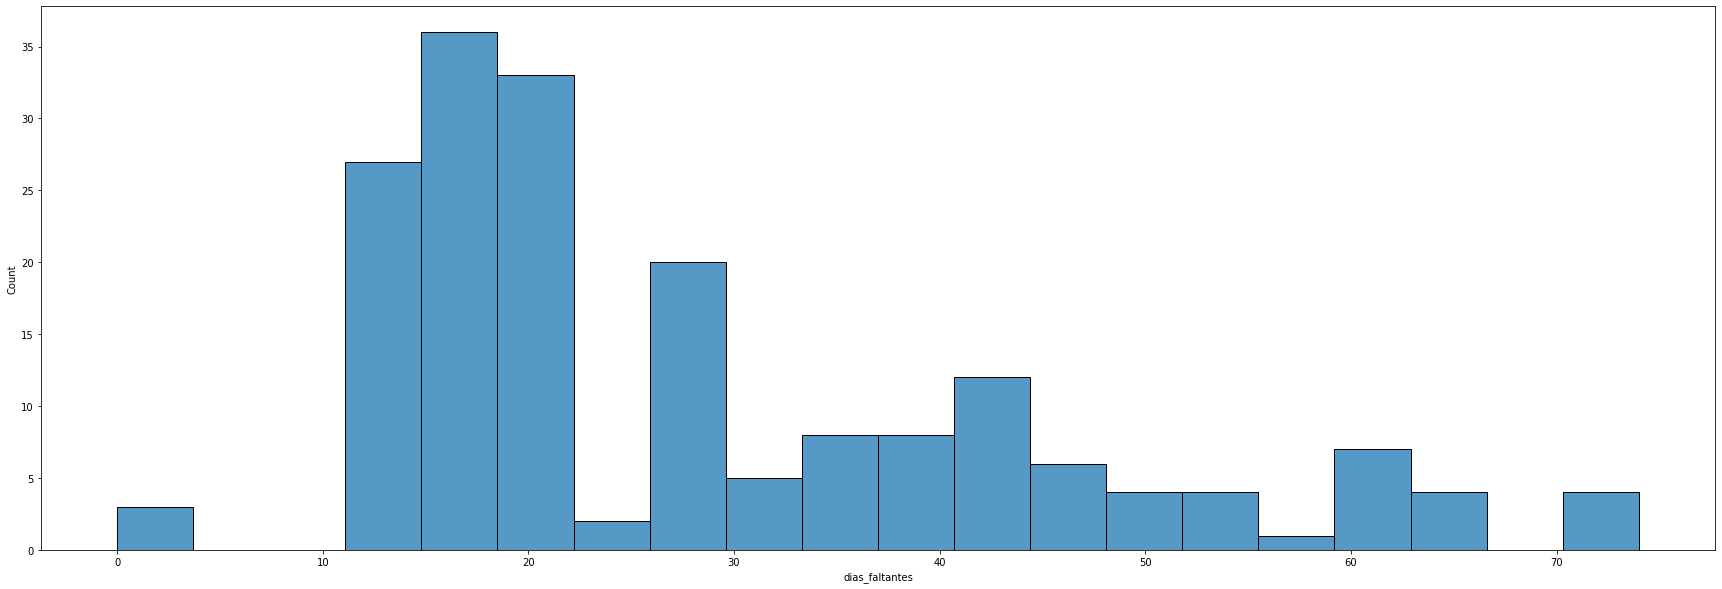

In [60]:
from matplotlib.pyplot import figure

figure(figsize=(30, 10))

sns.histplot(data=df_adic, x='dias_faltantes', bins=20)
plt.show()

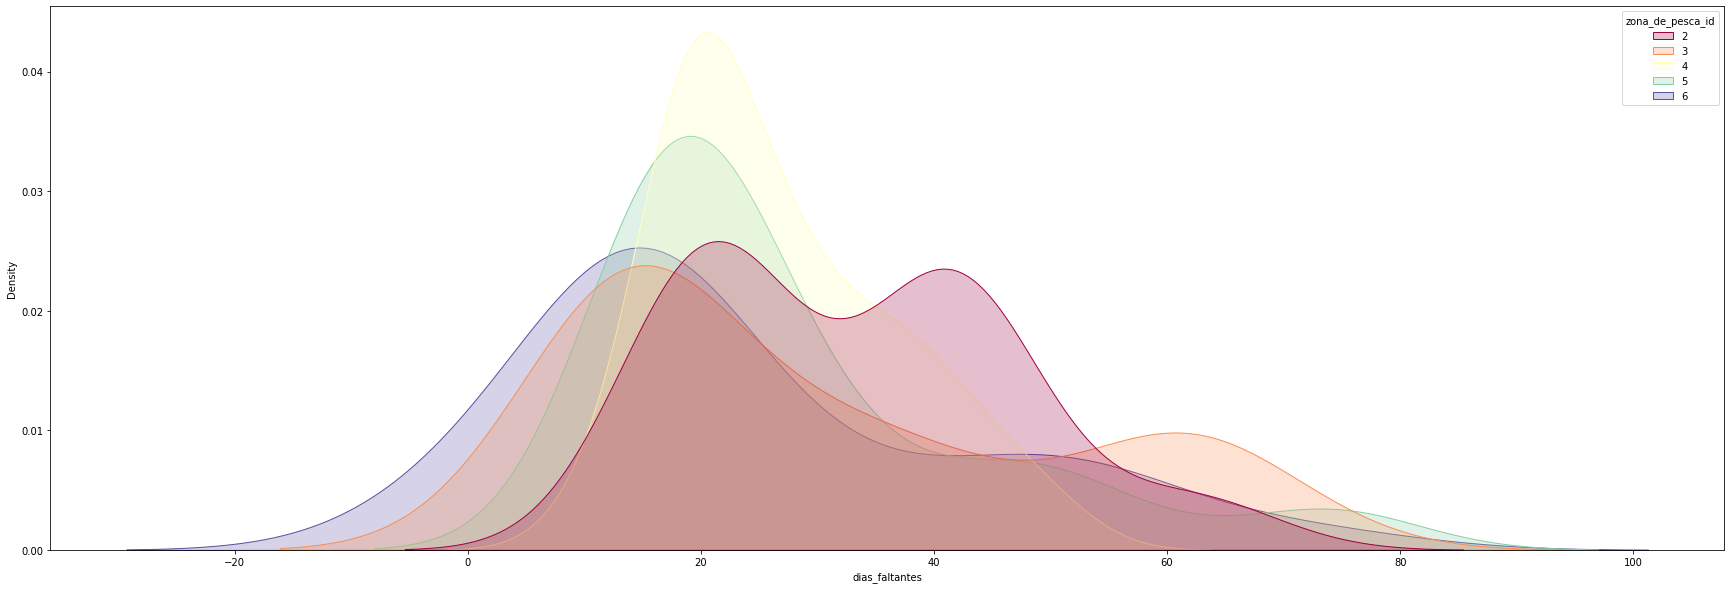

In [63]:
from matplotlib.pyplot import figure

figure(figsize=(30, 10))

sns.kdeplot(data=df_adic, x='dias_faltantes', hue='zona_de_pesca_id', palette="Spectral", fill=True, common_norm=False)
plt.show()